In [1]:
import pysubgroup as ps
import pandas as pd
from graph_pipeline.main import *
from tqdm.auto import tqdm
import numpy as np
import multiprocessing as mp
from itertools import product
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import seaborn as sns
import statsmodels.api as sm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

def filter_on_stats(stat_df, min_replies=10, max_replies=350, language='en', acyclic=True):
    filter_array = np.logical_and(stat_df.replies >= min_replies ,stat_df.language == language)
    filter_array = np.logical_and(filter_array, stat_df.is_acyclic == acyclic)
    filter_array = np.logical_and(filter_array,stat_df.replies <= max_replies)
    filter_array = filter_array.to_numpy()
    return filter_array

def drop_useless(graph_feature_df):
    return graph_feature_df.drop(columns=["network_diameter", "network_radius", "closeness_centralization", "102", "111D", "111U", 
                                          "030C", "201", "120D", "120U", "120C", "210", "300" ])

In [2]:
stat_df = pd.read_pickle("archive_collection_extracted/stat_df")
graph_features_all = pd.read_pickle("archive_collection_extracted/graph_features_all")

In [3]:
graph_features_clean = drop_useless(graph_features_all).drop(columns=["003","max_degree"])

In [5]:
graph_features_clean.describe()

,average_degree,density,longest_path,transitivity,average_clustering,degree_centralization,betweenness_centralization,012,021D,021U,021C,030T
count,788034.000000,788034.000000,788034.000000,788034.000000,788034.000000,695437.000000,788034.000000,695437.000000,695437.000000,695437.000000,695437.000000,695437.000000
mean,1.733873,0.170053,0.287100,0.054778,0.009852,0.600335,0.039149,0.172408,0.002700,0.219646,0.065254,0.003039
std,0.395908,0.155705,0.168515,0.130479,0.035750,0.277440,0.090696,0.165858,0.023062,0.294452,0.185972,0.039478
min,0.666667,0.000255,0.003282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.500000,0.045238,0.153846,0.000000,0.000000,0.362401,0.000000,0.015641,0.000000,0.018725,0.000064,0.000000
50%,1.800000,0.119048,0.250000,0.000000,0.000000,0.569170,0.007700,0.135835,0.000000,0.091667,0.005647,0.000000
75%,2.000000,0.250000,0.400000,0.000000,0.000000,0.861111,0.033333,0.290909,0.000007,0.285714,0.033333,0.000000
max,24.181818,0.500000,0.958333,0.500000,0.500000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000


# Random Forests 

In [6]:
graph_features_all = graph_features_clean
graph_features_all['replies'] = stat_df.set_index('thread_id').replies
scaler = StandardScaler()


clf = RandomForestClassifier(random_state=42)

cv = StratifiedKFold(
    n_splits=5
)
cv_results_rf = {}
for min_replies, max_replies in tqdm([(10, 50), (10, 100), (10, 350), (50,100), 
                                      (50, 150), (50, 250), (50, 350), (100, 150), 
                                      (100, 250), (100, 350), (150,250), (150, 350), 
                                      (200, 350), (250, 350)]):
    print(min_replies, max_replies)
    filter_array = filter_on_stats(stat_df, min_replies=min_replies, max_replies=max_replies)
    graph_features = graph_features_all.loc[filter_array]
    graph_features = graph_features.dropna()
    X = graph_features.drop(columns=["board", "replies"]).to_numpy()
    y = graph_features.board.to_numpy()
    scaler.fit(X)
    X_transformed = scaler.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, 
                                                        random_state=42, stratify=y)
    count = Counter(y_train)
    
    param_grid = { 
    'n_estimators': [50, 100, 125, 150, 175, 200],
    'max_features': ['auto'],
    'max_depth' : [10, 13, 15, None],
    'criterion' :['gini'],
    'class_weight': ['balanced', {label:1/count[label] for label in count.keys()}],
    'random_state': [42]
    }

    search = GridSearchCV(
        estimator=clf, param_grid=param_grid,
        scoring='f1_macro', cv=cv,
        n_jobs=20, refit = True
    )
    search.fit(X_train, y_train)
    print(search.best_params_)
    key = f"{min_replies}-{max_replies}"
    cv_results_rf[key] = {"model":search, 
                      'X_test': X_test, 
                      'X_train': X_train, 
                      'y_test':y_test, 
                      "y_train":y_train
                     }
    cv_results_rf[key]['report']  = classification_report(cv_results_rf[key]['y_test'], cv_results_rf[key]['model'].predict(cv_results_rf[key]['X_test']))
    cv_results_rf[key]['report_dict']  = classification_report(cv_results_rf[key]['y_test'], cv_results_rf[key]['model'].predict(cv_results_rf[key]['X_test']), output_dict=True)
    cv_results_rf[key]['best_params'] = cv_results_rf[key]['model'].best_params_
    print(classification_report(cv_results_rf[key]['y_test'], cv_results_rf[key]['model'].predict(cv_results_rf[key]['X_test'])))

  0%|          | 0/14 [00:00<?, ?it/s]

10 50


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': {'v': 2.4514009756575884e-05, 'mu': 6.858710562414266e-05, 'int': 4.112180277983387e-05, 'pol': 1.8767007600638077e-05, 'tv': 3.922030042750128e-05, 'biz': 4.9509852460639665e-05, 'r9k': 6.692992436918547e-05}, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200, 'random_state': 42}
              precision    recall  f1-score   support

         biz       0.14      0.16      0.15      5050
         int       0.15      0.12      0.13      6079
          mu       0.13      0.13      0.13      3645
         pol       0.39      0.38      0.38     13321
         r9k       0.16      0.32      0.21      3735
          tv       0.17      0.25      0.20      6375
           v       0.24      0.11      0.16     10199

    accuracy                           0.23     48404
   macro avg       0.20      0.21      0.20     48404
weighted avg       0.24      0.23      0.22     48404

10 100


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': {'tv': 3.37997701615629e-05, 'v': 2.0376558806748717e-05, 'pol': 1.524343770007012e-05, 'int': 3.622925874936599e-05, 'mu': 6.185439475474733e-05, 'r9k': 6.0727515637335276e-05, 'biz': 4.516915849857717e-05}, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 175, 'random_state': 42}
              precision    recall  f1-score   support

         biz       0.13      0.18      0.15      5534
         int       0.16      0.14      0.15      6901
          mu       0.13      0.13      0.13      4041
         pol       0.44      0.40      0.42     16401
         r9k       0.16      0.31      0.21      4117
          tv       0.18      0.25      0.21      7397
           v       0.29      0.13      0.18     12269

    accuracy                           0.24     56660
   macro avg       0.21      0.22      0.21     56660
weighted avg       0.27      0.24      0.25     56660

10 350


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': {'int': 3.195194427580918e-05, 'tv': 2.9887324785558443e-05, 'v': 1.745413924912293e-05, 'pol': 1.1361570623522995e-05, 'biz': 4.242321398269133e-05, 'mu': 5.302789267154523e-05, 'r9k': 5.81767409389726e-05}, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200, 'random_state': 42}
              precision    recall  f1-score   support

         biz       0.13      0.22      0.16      5893
         int       0.17      0.14      0.15      7824
          mu       0.22      0.18      0.20      4714
         pol       0.56      0.41      0.48     22005
         r9k       0.14      0.36      0.20      4297
          tv       0.18      0.28      0.22      8365
           v       0.33      0.17      0.22     14324

    accuracy                           0.28     67422
   macro avg       0.25      0.25      0.23     67422
weighted avg       0.33      0.28      0.29     67422

50 100
{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 

/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': {'tv': 0.0001490979573579842, 'v': 6.585879873551106e-05, 'biz': 0.0003663003663003663, 'pol': 4.358627903935841e-05, 'int': 0.00020181634712411706, 'r9k': 0.0004470272686633885, 'mu': 0.00045045045045045046}, 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200, 'random_state': 42}
              precision    recall  f1-score   support

         biz       0.08      0.07      0.07       682
         int       0.19      0.30      0.23      1239
          mu       0.27      0.14      0.18       555
         pol       0.58      0.61      0.59      5736
         r9k       0.15      0.17      0.16       559
          tv       0.22      0.25      0.23      1677
           v       0.40      0.30      0.34      3796

    accuracy                           0.39     14244
   macro avg       0.27      0.26      0.26     14244
weighted avg       0.40      0.39      0.39     14244

50 350


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 200, 'random_state': 42}
              precision    recall  f1-score   support

         biz       0.14      0.16      0.15       867
         int       0.25      0.18      0.21      1780
          mu       0.47      0.37      0.41      1087
         pol       0.67      0.60      0.63      8785
         r9k       0.12      0.32      0.18       580
          tv       0.23      0.26      0.24      2037
           v       0.36      0.39      0.37      4196

    accuracy                           0.44     19332
   macro avg       0.32      0.33      0.31     19332
weighted avg       0.47      0.44      0.45     19332

100 150
{'class_weight': {'int': 0.0010570824524312897, 'v': 0.00028312570781426955, 'pol': 0.0001836884643644379, 'tv': 0.00072992700729927, 'mu': 0.002824858757062147, 'r9k': 0.0024154589371980675, 'biz': 0.002207505518763797}, 'criterion': 'gini', 'max_depth': 10, 'ma

In [7]:
with open("archive_collection_extracted/cv_restults_rf", "wb") as f:
    pickle.dump(cv_results_rf, f)

In [46]:
with open("archive_collection_extracted/cv_restults_rf", "rb") as f:
    cv_results_rf = pickle.load(f)

In [49]:
multi_dict = {}
param_dict = {}
for key in cv_results_rf.keys():
    multi_dict[key] = pd.DataFrame(cv_results_rf[key]['report_dict'])
    param_dict[key] = cv_results_rf[key]['best_params']
df = pd.concat(multi_dict.values(), keys=multi_dict.keys())
param_df = pd.DataFrame(param_dict)
df.round(2).to_excel("archive_collection_extracted/classification_report_rf.xlsx")
param_df.to_excel("archive_collection_extracted/classification_params_rf.xlsx")

In [65]:
viz_dict_rf = {"precision":{},
                "precision_weighted":{},
                "recall":{},
                "recall_weighted":{},
                "f1":{},
                "f1_weigthed":{},
                #"accuracy":{}
               }
for key in cv_results_rf.keys():
    df =  pd.DataFrame(cv_results_rf[key]['report_dict']).transpose()
    viz_dict_rf["precision"][key] = df.precision.loc["macro avg"]
    viz_dict_rf["precision_weighted"][key] = df.precision.loc["weighted avg"]
    viz_dict_rf["recall"][key] = df.recall.loc["macro avg"]
    viz_dict_rf["recall_weighted"][key] = df.recall.loc["weighted avg"]
    viz_dict_rf["f1"][key] = df["f1-score"].loc["macro avg"]
    viz_dict_rf["f1_weigthed"][key] = df["f1-score"].loc["weighted avg"]
    #viz_dict_rf["accuracy"][key] = df["f1-score"].loc["accuracy"]


In [66]:
viz_dict_rf

{'precision': {'10-50': 0.19808913184129703,
  '10-100': 0.21167455220796053,
  '10-350': 0.24937616441300967,
  '50-100': 0.26679728219199383,
  '50-150': 0.26777598359385646,
  '50-250': 0.269034624550374,
  '50-350': 0.3203163674772817,
  '100-150': 0.2593850970256406,
  '100-250': 0.283160812689562,
  '100-350': 0.36247726871463876,
  '150-250': 0.31010862273415046,
  '150-350': 0.377656336728013,
  '200-350': 0.3850854865468683,
  '250-350': 0.3897575463638363},
 'precision_weighted': {'10-50': 0.2366238738264187,
  '10-100': 0.26573015704662734,
  '10-350': 0.3337371177321947,
  '50-100': 0.35587842028463157,
  '50-150': 0.37547634710830274,
  '50-250': 0.40171744987308794,
  '50-350': 0.46580489592512897,
  '100-150': 0.4360309703774971,
  '100-250': 0.4534915184729965,
  '100-350': 0.5477311303196074,
  '150-250': 0.47046789796908906,
  '150-350': 0.5766720050991433,
  '200-350': 0.600760388720519,
  '250-350': 0.6025107933848318},
 'recall': {'10-50': 0.20909912883544532,
  '1

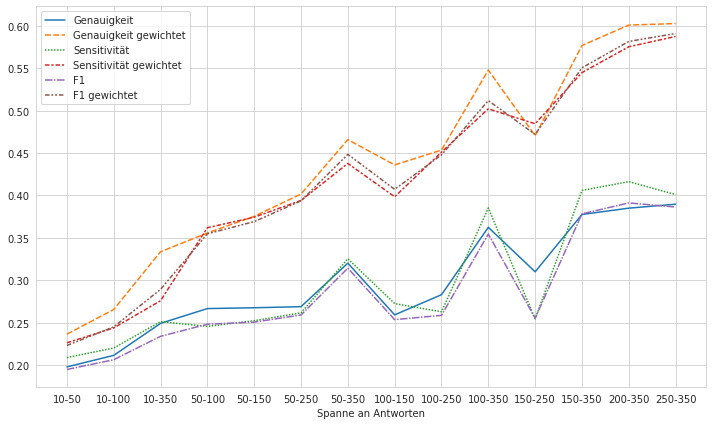

In [67]:
sns.set_style("whitegrid")
plt.figure(figsize=(12,7))
sns.lineplot(data=viz_dict_rf).set_xlabel("Spanne an Antworten")
plt.legend(["Genauigkeit", "Genauigkeit gewichtet", "Sensitivität", "Sensitivität gewichtet", "F1", "F1 gewichtet"])

In [88]:
pd.DataFrame(cv_results_rf["10-350"]['report_dict']).transpose().round(2).join(pd.DataFrame(cv_results_rf["250-350"]['report_dict']).transpose().round(2), lsuffix=" (10-350)", rsuffix=" (250-350)", how="left").to_excel("archive_collection_extracted/classification_report_rf_10-350_250-350.xlsx")

Text(0, 0.5, 'Tatsächliches Board')

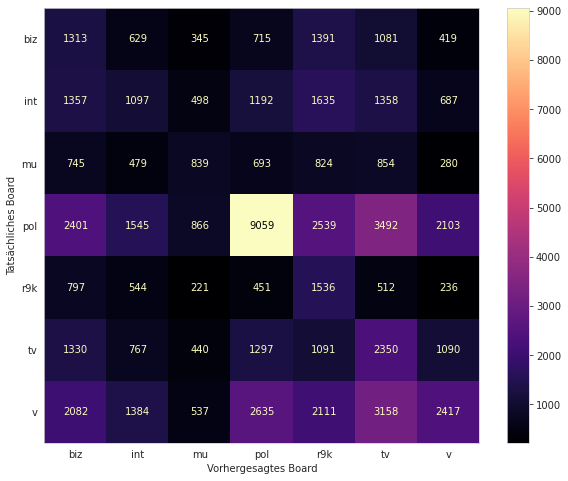

In [50]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig, ax = plt.subplots(figsize=(10,8))
g=plot_confusion_matrix(estimator=cv_results_rf["10-350"]["model"], X=cv_results_rf["10-350"]["X_test"], y_true=cv_results_rf["10-350"]["y_test"],cmap="magma", ax=ax)
g.ax_.set_xlabel('Vorhergesagtes Board')
g.ax_.set_ylabel('Tatsächliches Board')

In [34]:
pd.DataFrame(cv_results_rf["10-350"]["report_dict"]).transpose()

,precision,recall,f1-score,support
biz,0.130973,0.222807,0.164970,5893.000000
int,0.170209,0.140210,0.153760,7824.000000
mu,0.223972,0.177980,0.198345,4714.000000
pol,0.564705,0.411679,0.476200,22005.000000
r9k,0.138043,0.357459,0.199170,4297.000000
tv,0.183522,0.280932,0.222012,8365.000000
v,0.334209,0.168738,0.224253,14324.000000
accuracy,0.276037,0.276037,0.276037,0.276037
macro avg,0.249376,0.251401,0.234102,67422.000000
weighted avg,0.333737,0.276037,0.289433,67422.000000


Text(0.5, 1.0, 'Threads mit 250-350 Antworten')

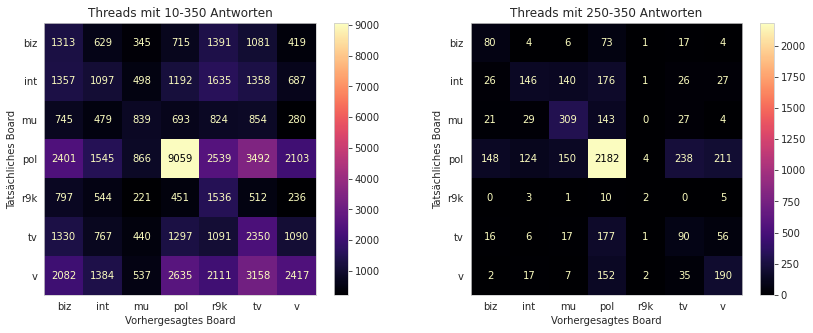

In [87]:
sns.set_style("whitegrid", {'axes.grid' : False})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
g1=plot_confusion_matrix(estimator=cv_results_rf["10-350"]["model"], X=cv_results_rf["10-350"]["X_test"], y_true=cv_results_rf["10-350"]["y_test"],cmap="magma", ax=ax1)
g1.ax_.set_xlabel('Vorhergesagtes Board')
g1.ax_.set_ylabel('Tatsächliches Board')
g1.ax_.set_title("Threads mit 10-350 Antworten")
g2=plot_confusion_matrix(estimator=cv_results_rf["250-350"]["model"], X=cv_results_rf["250-350"]["X_test"], y_true=cv_results_rf["250-350"]["y_test"],cmap="magma", ax=ax2)
g2.ax_.set_xlabel('Vorhergesagtes Board')
g2.ax_.set_ylabel('Tatsächliches Board')
g2.ax_.set_title("Threads mit 250-350 Antworten")

In [95]:
result_dict_10 = {}

In [ ]:
filter_array = filter_on_stats(stat_df, min_replies=10, max_replies=350)
for board in tqdm(["pol", "mu", "v"]):
    bins = 30
    for a in tqdm([0, 0.5, 1], desc="alphas"):
        ps_target = ps.BinaryTarget(target_attribute='board', target_value=board)
        ps_search_space = ps.create_selectors(graph_features_all[filter_array], ignore=['board'], nbins =bins)
        ps_task = ps.SubgroupDiscoveryTask(graph_features_all[filter_array], ps_target, ps_search_space, qf=ps.GeneralizationAware_StandardQF(a))
        result_dict_10[f"{topic}_GA_{a}_SDFS_bins={bins}"] = ps.SimpleDFS().execute(ps_task)
        ps_task = ps.SubgroupDiscoveryTask(subgroup_dominant_topic[filter_array], ps_target, ps_search_space, qf=ps.StandardQF(a))
        result_dict_10[f"{topic}_SQF_{a}_BFS_bins={bins}"] = ps.BestFirstSearch().execute(ps_task)


  0%|          | 0/3 [00:00<?, ?it/s]

alphas:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
result_dict_250 = {}

In [ ]:
filter_array = filter_on_stats(stat_df, min_replies=250, max_replies=350)
for board in tqdm(["pol", "mu", "v"]):
    bins = 30
    for a in tqdm([0, 0.5, 1], desc="alphas"):
        ps_target = ps.BinaryTarget(target_attribute='board', target_value=board)
        ps_search_space = ps.create_selectors(graph_features_all[filter_array], ignore=['board'], nbins =bins)
        ps_task = ps.SubgroupDiscoveryTask(graph_features_all[filter_array], ps_target, ps_search_space, qf=ps.GeneralizationAware_StandardQF(a))
        result_dict_250[f"{topic}_GA_{a}_SDFS_bins={bins}"] = ps.SimpleDFS().execute(ps_task)
        ps_task = ps.SubgroupDiscoveryTask(subgroup_dominant_topic[filter_array], ps_target, ps_search_space, qf=ps.StandardQF(a))
        result_dict_250[f"{topic}_SQF_{a}_BFS_bins={bins}"] = ps.BestFirstSearch().execute(ps_task)


In [86]:
graph_features_all.loc[filter_on_stats(stat_df)].dropna()

,average_degree,density,longest_path,transitivity,average_clustering,degree_centralization,betweenness_centralization,012,021D,021U,021C,030T,board,replies
59108164,1.933333,0.033333,0.800000,0.000000,0.000000,0.076355,0.085740,0.184729,0.000246,0.001478,0.005911,0.000000e+00,r9k,28
59086906,1.818182,0.090909,0.454545,0.000000,0.000000,0.266667,0.048889,0.400000,0.000000,0.036364,0.036364,0.000000e+00,r9k,10
59100871,1.846154,0.076923,0.230769,0.000000,0.000000,0.310606,0.027146,0.314685,0.000000,0.048951,0.024476,0.000000e+00,r9k,12
58317855,1.857143,0.071429,0.285714,0.000000,0.000000,0.371795,0.019724,0.302198,0.000000,0.043956,0.019231,0.000000e+00,r9k,13
58716717,2.105263,0.058480,0.263158,0.000000,0.000000,0.490196,0.046659,0.220846,0.003096,0.047472,0.014448,0.000000e+00,r9k,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511743294,2.000000,0.035714,0.068966,0.500000,0.034584,0.652116,0.002315,0.114395,0.000000,0.047072,0.002463,2.736727e-04,v,28
510088973,2.313253,0.014105,0.132530,0.214286,0.052292,0.283499,0.004722,0.075130,0.000131,0.003679,0.000795,9.795279e-05,v,82
511245827,2.072727,0.003782,0.050909,0.071429,0.006061,0.223991,0.000726,0.021311,0.000004,0.000618,0.000069,5.833582e-07,v,274
517092780,2.057971,0.015132,0.188406,0.333333,0.022947,0.286874,0.007844,0.080181,0.000019,0.004275,0.000954,3.817231e-05,v,68


In [68]:
pd.DataFrame(cv_results_rf["10-350"]["report_dict"]).transpose()

,precision,recall,f1-score,support
biz,0.130973,0.222807,0.164970,5893.000000
int,0.170209,0.140210,0.153760,7824.000000
mu,0.223972,0.177980,0.198345,4714.000000
pol,0.564705,0.411679,0.476200,22005.000000
r9k,0.138043,0.357459,0.199170,4297.000000
tv,0.183522,0.280932,0.222012,8365.000000
v,0.334209,0.168738,0.224253,14324.000000
accuracy,0.276037,0.276037,0.276037,0.276037
macro avg,0.249376,0.251401,0.234102,67422.000000
weighted avg,0.333737,0.276037,0.289433,67422.000000


In [46]:
pd.DataFrame(cv_results_rf["250-350"]["report_dict"]).transpose()

,precision,recall,f1-score,support
biz,0.273038,0.432432,0.334728,185.000000
int,0.443769,0.269373,0.335247,542.000000
mu,0.490476,0.579737,0.531384,533.000000
pol,0.749056,0.713772,0.730988,3057.000000
r9k,0.181818,0.095238,0.125000,21.000000
tv,0.207852,0.247934,0.226131,363.000000
v,0.382294,0.469136,0.421286,405.000000
accuracy,0.587348,0.587348,0.587348,0.587348
macro avg,0.389758,0.401089,0.386395,5106.000000
weighted avg,0.602511,0.587348,0.590838,5106.000000


In [45]:
pd.DataFrame(cv_results_rf["200-350"]["report_dict"]).transpose()

,precision,recall,f1-score,support
biz,0.278146,0.403846,0.329412,208.0000
int,0.436364,0.280936,0.341811,598.0000
mu,0.524390,0.623188,0.569536,552.0000
pol,0.757805,0.678047,0.715711,3544.0000
r9k,0.066667,0.119048,0.085470,42.0000
tv,0.265060,0.234542,0.248869,469.0000
v,0.367167,0.574586,0.448034,724.0000
accuracy,0.575200,0.575200,0.575200,0.5752
macro avg,0.385085,0.416313,0.391263,6137.0000
weighted avg,0.600760,0.575200,0.581468,6137.0000


# binary log mit statsmodels

In [10]:
scaler = StandardScaler()

result_dict_stats_binary = {}
for min_replies, max_replies in tqdm([(10, 350), (250, 350)]):
    print(min_replies, max_replies)
    filter_array = filter_on_stats(stat_df, min_replies=min_replies)
    graph_features = graph_features_clean.loc[filter_array]
    graph_features = graph_features.dropna()
    X = graph_features.drop(columns=["board"]).astype(np.float64)
    y = graph_features.board 
    scaler.fit(X)
    X_transformed = scaler.transform(X)
    key = f"{min_replies}-{max_replies}"
    result_dict_stats_binary[key] = {}
    try:
        temp_dict = {}
        for board in ["pol", "tv", "v"] if min_replies == 10 else ["mu", "pol", "v"]:
            y_train_binary = y == board
            print(min_replies, max_replies)
            print(y_train_binary.sum())
            model = sm.Logit(endog=y_train_binary, exog=sm.add_constant(X))
            result = model.fit()
            temp_dict[board] = {'model': model,
                                'result': result,
                                }
        result_dict_stats_binary[key]['predictors'] = temp_dict
    except Exception as e:
        print(f"EXCEPTION!!! {e} !!!")
        continue

  0%|          | 0/2 [00:00<?, ?it/s]

10 350
10 350
110021
Optimization terminated successfully.
         Current function value: 0.596724
         Iterations 6
10 350
41824
Optimization terminated successfully.
         Current function value: 0.369151
         Iterations 7
10 350
71617
Optimization terminated successfully.
         Current function value: 0.514381
         Iterations 30
250 350
250 350
2663
         Current function value: 0.292359
         Iterations: 35
250 350
15286


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


         Current function value: 0.667332
         Iterations: 35
250 350
2027


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


         Current function value: inf
         Iterations: 35
EXCEPTION!!! Singular matrix !!!


/home/hengelhardt/masterarbeit/.venv/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1863: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [12]:
for min_replies in [10]:
    for key in result_dict_stats_binary[f"{min_replies}-350"]["predictors"].keys():
        print(key)
        pd.DataFrame(result_dict_stats_binary[f"{min_replies}-350"]["predictors"][key]["result"].summary().tables[1]).transpose().to_excel(f"archive_collection_extracted/log_reg_result{min_replies}_board_{key}.xlsx")

pol
tv
v


# Subgroup Discovery

In [23]:
def search_subgroups(data, min_replies, target_attribute, target, a):
    result_dict = {}
    ps_target = ps.BinaryTarget(target_attribute=target_attribute, target_value=target)
    ps_search_space = ps.create_selectors(data, ignore=[target_attribute], nbins =30)
    ps_task = ps.SubgroupDiscoveryTask(data, ps_target, ps_search_space, qf=ps.GeneralizationAware_StandardQF(a))
    result_dict[f"{min_replies}_{target}_GA_{a}_SDFS"] = ps.SimpleDFS().execute(ps_task).to_dataframe()
    ps_task = ps.SubgroupDiscoveryTask(data, ps_target, ps_search_space, qf=ps.StandardQF(a))
    result_dict[f"{min_replies}_{target}_SQF_{a}_BFS"] = ps.BestFirstSearch().execute(ps_task).to_dataframe()
    return result_dict

In [ ]:
subgroup_combs = []
[subgroup_combs.append(prod) for prod in product([10], ["board"], ["pol", "tv", "v"], [0.5, 1])]
[subgroup_combs.append(prod) for prod in product([250], ["board"], ["mu", "pol", "v"], [0.5, 1])]
pool = mp.Pool(processes=18)
subgroup_archive_results = [pool.apply_async(search_subgroups, (graph_features_clean.loc[filter_on_stats(stat_df, min_replies=item[0])], item[0], item[1], item[2], item[3],))
           for item in tqdm(subgroup_combs,desc="adding search to mp pool")]
subgroup_archive_results = [result.get() for result in tqdm(subgroup_archive_results, desc="retrieving subgroups")]

adding search to mp pool:   0%|          | 0/18 [00:00<?, ?it/s]

retrieving subgroups:   0%|          | 0/18 [00:00<?, ?it/s]

In [25]:
subgroup_archive_results

[{'10_pol_GA_0_SDFS':     quality                                           subgroup  size_sg  \
  0  0.673631  021U: [0.02:0.03[ AND average_degree: [1.82:1....      1.0   
  1  0.673631  021U: [0.02:0.03[ AND average_degree: [1.82:1....      1.0   
  2  0.673631  021U: [0.03:0.03[ AND average_degree: [1.82:1....      1.0   
  3  0.673631  average_degree: [1.82:1.83[ AND degree_central...      3.0   
  4  0.673631  average_degree: [1.82:1.83[ AND betweenness_ce...      1.0   
  5  0.673631  average_degree: [1.82:1.83[ AND density: [0.03...      1.0   
  6  0.673631  average_degree: [1.82:1.83[ AND degree_central...      1.0   
  7  0.673631  average_degree: [1.82:1.83[ AND density: [0.03...      2.0   
  8  0.673631  average_degree: [1.82:1.83[ AND longest_path: ...      1.0   
  9  0.673631  average_degree: [1.82:1.83[ AND betweenness_ce...      1.0   
  
     size_dataset  positives_sg  positives_dataset  size_complement  \
  0      337106.0           1.0           110021.0         

In [37]:
list(subgroup_archive_results[0].keys())[0].split("_")

['10', 'pol', 'GA', '0', 'SDFS']

In [32]:
from pprint import pprint

In [44]:
for sg_res in subgroup_archive_results:
    for res in sg_res.keys():
        if res.split("_")[3] != "0":
            if res.split("_")[0] == "250":
                if res.split("_")[1] in ['pol']:
                    print(res)
                    pprint(sg_res[res][["quality", "subgroup", "size_sg", "positives_sg", "positives_dataset", "target_share_sg", "lift"]])


250_pol_GA_0.5_SDFS
    quality                            subgroup  size_sg  positives_sg  \
0  0.036998         degree_centralization>=0.53    851.0         682.0   
1  0.035496                   021U: [0.00:0.00[    851.0         675.0   
2  0.035281                          021U>=0.00    851.0         674.0   
3  0.032921                   021D: [0.00:0.00[    851.0         663.0   
4  0.032854                            012<0.01    850.0         662.0   
5  0.029488                   021D: [0.00:0.00[    851.0         647.0   
6  0.029274  degree_centralization: [0.47:0.53[    851.0         646.0   
7  0.025841    betweenness_centralization>=0.01    851.0         630.0   
8  0.025412                average_degree>=2.36    851.0         628.0   
9  0.024769                   021D: [0.00:0.00[    851.0         625.0   

   positives_dataset  target_share_sg      lift  
0            15286.0         0.801410  1.338427  
1            15286.0         0.793184  1.324690  
2            15

In [ ]:
result_dict = {}
for min_replies, max_replies in tqdm([(10, 50), (10, 100), (10, 350), (50,100), 
                                      (50, 150), (50, 250), (50, 350), (100, 150), 
                                      (100, 250), (100, 350), (150,250), (150, 350), 
                                      (200, 350), (250, 350)]):
    print(min_replies, max_replies)
    filter_array = filter_on_stats(stat_df, min_replies=min_replies, max_replies=max_replies)
    for board in graph_features_clean.board.unique():
        print(board)
        ps_target = ps.BinaryTarget(target_attribute='board', target_value=board)
        ps_search_space = ps.create_selectors(graph_features_clean[filter_array], ignore=['board'], nbins =30)
        ps_task = ps.SubgroupDiscoveryTask(graph_features_clean[filter_array], ps_target, ps_search_space, qf=ps.StandardQF(0.5))
        result_dict[f"{min_replies}-{max_replies}_{board}"] = ps.BeamSearchearch().execute(ps_task)
        break